# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from numpy.random import RandomState
from IPython import display as ICD

In [2]:
xn = 42
random_state = 42

## Загрузка и подготовка данных

### Загрузка и ознакомление с данными

In [3]:
data_list = []
for i in range(3):
    try:
        df = pd.read_csv(f'geo_data_{i}.csv')
    except:
        df = pd.read_csv(f'/yandex/practicum/datas/geo_data_{i}.csv')
    data_list.append(df)
    
geo_data_0, geo_data_1, geo_data_2 = data_list

In [4]:
for df in (geo_data_0,  geo_data_1, geo_data_2):
    ICD.display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Типы данных совпадают, пропущенных значений нет.

Посмотрим как выглядят данные.

In [5]:
for df in (geo_data_0,  geo_data_1, geo_data_2):
    ICD.display(df.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


* `id` - признак, который нам не понадобится;
* можно заметить, что есть заметный разброс значений в признаке `product`;
* признаки необходимо отмасштабировать.

Посмотрим на распределение

In [6]:
for df in (geo_data_0,  geo_data_1, geo_data_2):
    ICD.display(df.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


* `f2` первых данных имеет выбросы;
* `f1` вторых данных имеет выбросы;
* все признаки имеют выбросы, кроме целевого;

Построим боксплоты для каждого признака и посмотрим на количество выбросов.

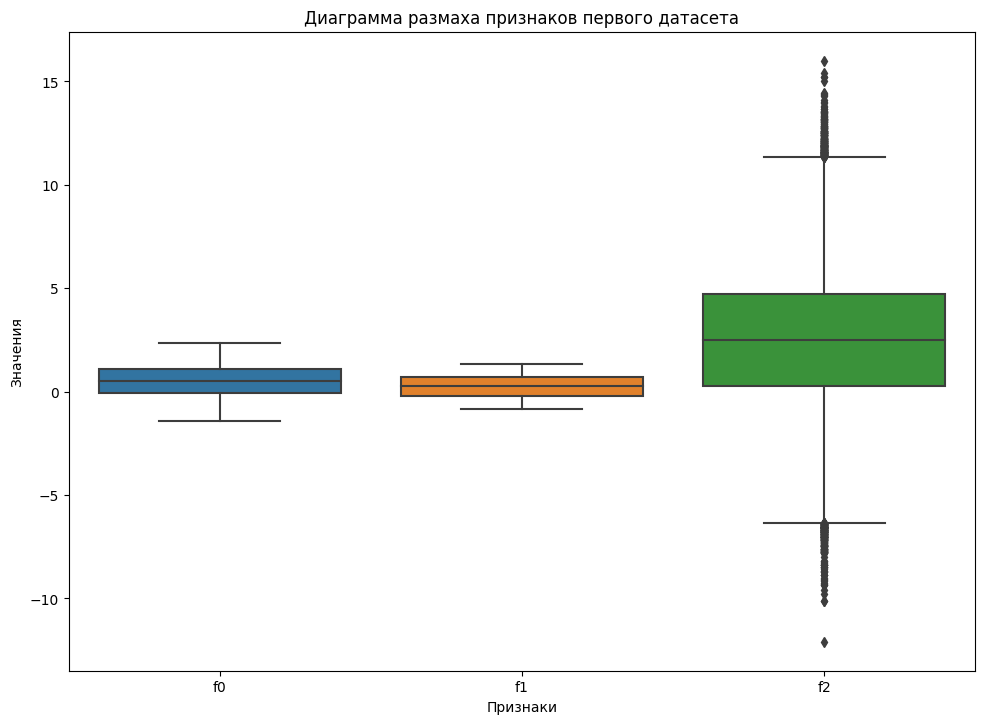

In [7]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=geo_data_0.drop('product', axis=1))\
.set(ylabel='Значения', xlabel='Признаки', title='Диаграмма размаха признаков первого датасета')

plt.show()

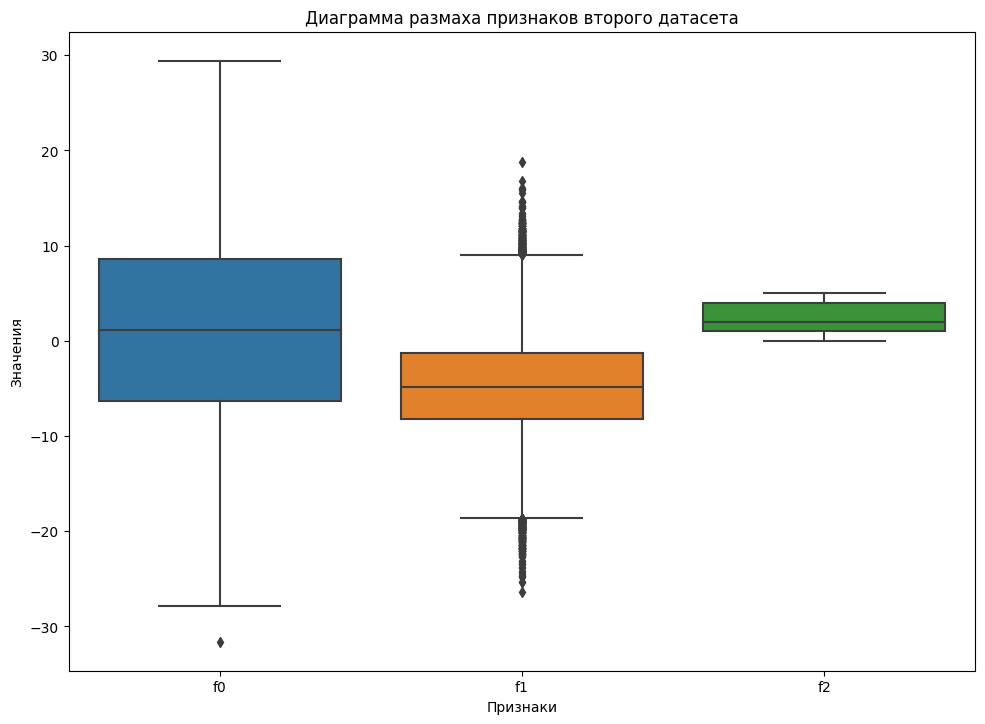

In [8]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=geo_data_1.drop('product', axis=1))\
.set(ylabel='Значения', xlabel='Признаки', title='Диаграмма размаха признаков второго датасета')
plt.show()

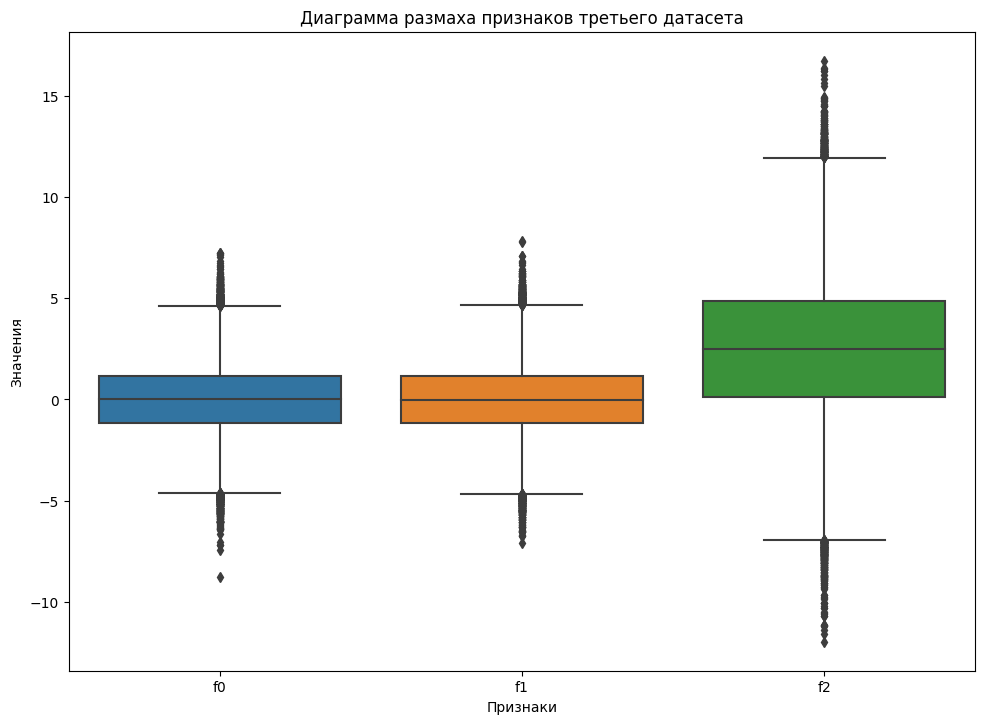

In [9]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=geo_data_2.drop('product', axis=1))\
.set(ylabel='Значения', xlabel='Признаки', title='Диаграмма размаха признаков третьего датасета')
plt.show()

* `f0` во втором датафрейме имеет мало выбросов;
* оставшиеся выбросы многочисленны.

Алгоритм линейной регрессии плохо работает при наличии выбросов. Для модели `Linear Regression` в тестовой выборке избавимся от выбросов, а на валидационной проверим метрику RMSE и R2. 

### Удаление ненужных признаков

In [10]:
for df in (geo_data_0,  geo_data_1, geo_data_2):
    df.drop('id', inplace=True, axis=1)

In [11]:
# check
for df in (geo_data_0,  geo_data_1, geo_data_2):
    ICD.display(df.head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


### Разбивка на выборки

Каждый датасет разделим на тренировочную и валидационную выборку в соотношении 75:25.

In [12]:
# напишем функцию для разбивки
def tts(data):
    X = data.drop('product', axis=1) # признаки
    y = data['product'] # целевая переменная
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
    return X_train, X_test, y_train, y_test
    
    

In [13]:
X_train_0, X_test_0, y_train_0, y_test_0 = tts(geo_data_0)
X_train_1, X_test_1, y_train_1, y_test_1 = tts(geo_data_1)
X_train_2, X_test_2, y_train_2, y_test_2 = tts(geo_data_2)

In [14]:
#check
datalist = [X_train_0, X_test_0, y_train_0, y_test_0, 
            X_train_1, X_test_1, y_train_1, y_test_1, 
            X_train_2, X_test_2, y_train_2, y_test_2]
for df in datalist:
    print(df.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)


### Сглаживание

Воспользуемся Robust Scaler для сглаживания признаков.

In [15]:
# напишем функцию для сглаживания
# обучим на тренировочной
def smoothing(X_train, X_test):
    scl = RobustScaler().fit(X_train)
    X_train = scl.transform(X_train)
    X_test = scl.transform(X_test)
    return X_train, X_test

In [16]:
X_train_0_scl, X_test_0_scl = smoothing(X_train_0, X_test_0)
X_train_1_scl, X_test_1_scl = smoothing(X_train_1, X_test_1)
X_train_2_scl, X_test_2_scl = smoothing(X_train_2, X_test_2)

In [17]:
#check
pd.DataFrame(X_train_0_scl).describe()

,0,1,2
count,7.500000e+04,75000.000000,7.500000e+04
mean,-2.440020e-03,-0.001466,-3.583371e-03
std,7.611886e-01,0.561208,7.328557e-01
min,-1.668015e+00,-1.226237,-2.856503e+00
25%,-5.040593e-01,-0.501916,-5.045821e-01
50%,-4.844351e-17,0.000000,5.008146e-17
75%,4.959407e-01,0.498084,4.954179e-01
max,1.622762e+00,1.202404,3.039773e+00


### Масштабирование

Перед обучением линейной модели проведем стандартизацию признаков.

In [18]:
def scale(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [19]:
X_train_0_scl, X_test_0_scl = scale(X_train_0_scl, X_test_0_scl)
X_train_1_scl, X_test_1_scl = scale(X_train_1_scl, X_test_1_scl)
X_train_2_scl, X_test_2_scl = scale(X_train_2_scl, X_test_2_scl)

In [20]:
#check
pd.DataFrame(X_train_0_scl).describe()

,0,1,2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,3.102703e-17,-7.200166e-18,-2.046363e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.188139e+00,-2.182397e+00,-3.892907e+00
25%,-6.589992e-01,-8.917428e-01,-6.836300e-01
50%,3.205561e-03,2.611348e-03,4.889632e-03
75%,6.547445e-01,8.901383e-01,6.809043e-01
max,2.135099e+00,2.145152e+00,4.152764e+00


Теперь обучим модель.

## Обучение и проверка модели

Обучим модель и проанализируем ответы.

### Linear Regressor

In [21]:
# для первого датасета
lr_0 = LinearRegression()
lr_0.fit(X_train_0_scl, y_train_0) # обучение на тренировочной сглаженной выборке
prd_valid_lr_0 = lr_0.predict(X_test_0_scl) # предсказания на тестовой выборке
# расчет метрик
lr_0_rmse = mean_squared_error(y_test_0, prd_valid_lr_0, squared=False)
lr_0_r2 = r2_score(y_test_0, prd_valid_lr_0)
mat_stock_mean_0 = prd_valid_lr_0.mean()

# для второго
lr_1 = LinearRegression()
lr_1.fit(X_train_1_scl, y_train_1)
prd_valid_lr_1 = lr_1.predict(X_test_1_scl)

lr_1_rmse = mean_squared_error(y_test_1, prd_valid_lr_1, squared=False)
lr_1_r2 = r2_score(y_test_1, prd_valid_lr_1)
mat_stock_mean_1 = prd_valid_lr_1.mean()

# для третьего
lr_2 = LinearRegression()
lr_2.fit(X_train_2_scl, y_train_2)
prd_valid_lr_2 = lr_2.predict(X_test_2_scl)

lr_2_rmse = mean_squared_error(y_test_2, prd_valid_lr_2, squared=False)
lr_2_r2 = r2_score(y_test_2, prd_valid_lr_2)
mat_stock_mean_2 = prd_valid_lr_2.mean()

Сравним результаты метрик

In [22]:
data_metrics = {'Data': ['GeoData_0', 'GeoData_1', 'GeoData_2'], 
     'RMSE': [lr_0_rmse, lr_1_rmse, lr_2_rmse],
     'R2': [lr_0_r2, lr_1_r2, lr_2_r2],
     'Средний предсказанный запас сырья': [mat_stock_mean_0, mat_stock_mean_1, mat_stock_mean_2]
    }
data_metrics_trans = pd.DataFrame(data=data_metrics).round(3)
data_metrics_trans

,Data,RMSE,R2,Средний предсказанный запас сырья
0,GeoData_0,37.757,0.273,92.399
1,GeoData_1,0.890,1.000,68.713
2,GeoData_2,40.146,0.196,94.771


* лучшие значения метрик были получены на втором датасете;
* первый и третий датасеты имеют примерно одинаковое количество сырья;
* второй датасет имеет в 1.5 раза меньше среднего запаса сырья.

## Подготовка к расчёту прибыли

На основе данных из тех.задания, расчитаем прибыль и среднее минимальное количество сырья для каждого региона.

### Постоянные переменные

In [23]:
# ислледуется 500 точек при разведке региона
EXPO_NODES = 500

# из них отбираются 200 лучших по результат предсказаний модели машинного обучения
BEST_NODES = 200

# бюджет на разработку скважин в одном региона = 10 млрд. рублей
FUNDING = 10 * 1e9

# цена за один баррель = 450 рублей, доход с единицы продукта = 450т. рублей
PRICE = 450000

# максимальная вероятноть убыточности региона = 2.5%
LOSS_RATE = 0.025

### Расчет минимального значения прибыльности продукта

Далее посчитаем минимальное среднее количество продукта в месторождениях региона для безубыточной разработки скважины.

Для этого необходимо сначало посчитать цену на разработку одной скважины.

In [24]:
# выделено 10 млдр. рублей для 200 точек
well_price = FUNDING/BEST_NODES

# для добычи без убытков
product_min = well_price/PRICE
round(product_min, 2)

111.11

То есть, для безубыточного бурения новой скважины необходимо, чтобы она приносила 111.11 тыс. баррелей продукта.

Из данных расчетов предсказанных объемов материала видно, что средние значения во всех трех регионах меньше, чем точка безубыточности. Следовательно, не всех скважины будут выгодны.

## Расчет прибыли и рисков

Для этого расчета необходимо из произведения цены за продукт и количества сырья в 200 предсказанных самых прибыльных точек вычесть выделенный бюджет.

Регионы будем называть по порядковму номеру. То есть, первый регион - `geo_data_0`, второй регион - `geo_data_1`, третий регион `geo_data_2`.

In [25]:
def rev(y_pred, y_test):
    # приводим данные к одному индексу
    pred_sorted = y_pred.sort_values(ascending=False) #отсортируем предсказания
    selected = y_test[pred_sorted.index][:BEST_NODES] #возьмем их индексы, чтобы выбрать ответы
    return selected.sum() * PRICE - FUNDING

С помощью техники Bootstrap рассчитаем возможные риски и прибыль.

In [26]:
# зададим random state из библиотеки numpy, чтобы при каждом вызове подвыборка менялась на случайную
state = RandomState(42)
# целевая метрика: 0.95 квантиль распределения
def bootstrap_profit(y_pred, y_test, region: str):
    values = [] # сохраним значения прибыли, чтобы в дальнейшем посчитать доверительный интервал
    y_test = pd.Series(y_test).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    for i in range(1000):
        subsample_y_test = y_test.sample(n=500, replace=True, random_state=state)
        subsample_y_pred = y_pred[subsample_y_test.index]
        values.append(rev(subsample_y_pred, subsample_y_test))
    
    values = pd.Series(values)/1e6
    prof_mean = values.mean()
    lower = values.quantile(0.025).round()
    upper = values.quantile(0.975).round()
    loss_rate = values.loc[values < 0].count()/values.count()
    print('Средняя прибыль в', region, 'регионе:', round(prof_mean), 'млн. рублей')
    print('Границы 95% доверительного интервала от', lower, 'до', upper, 'млн. рублей')
    print('Вероятность потерь', "{:.1%}".format(loss_rate))
    print()
    return prof_mean.round(), lower, upper, loss_rate*100

In [27]:
prof_data = []
samples = {'a':[prd_valid_lr_0, y_test_0, 'первом'],
'b':[prd_valid_lr_1, y_test_1, 'втором'],
'c':[prd_valid_lr_2, y_test_2, 'третьем']
}

for x, y in samples.items():
    prof_data.append(bootstrap_profit(y[0], y[1], y[2]))
    

Средняя прибыль в первом регионе: 428 млн. рублей
Границы 95% доверительного интервала от -97.0 до 954.0 млн. рублей
Вероятность потерь 5.5%

Средняя прибыль в втором регионе: 512 млн. рублей
Границы 95% доверительного интервала от 92.0 до 921.0 млн. рублей
Вероятность потерь 0.6%

Средняя прибыль в третьем регионе: 409 млн. рублей
Границы 95% доверительного интервала от -121.0 до 961.0 млн. рублей
Вероятность потерь 7.5%



In [28]:
pd.DataFrame(prof_data).rename(columns={0:'Средняя прибыль (млн.рублей)', 
                                        1:'Нижняя граница квантиля (млн.рублей)', 
                                        2:'Верхняя граница квантиля (млн.рублей)',
                                       3:'Вероятность потерь (5%)'})

,Средняя прибыль (млн.рублей),Нижняя граница квантиля (млн.рублей),Верхняя граница квантиля (млн.рублей),Вероятность потерь (5%)
0,428.0,-97.0,954.0,5.5
1,512.0,92.0,921.0,0.6
2,409.0,-121.0,961.0,7.5


Параметрам тех.задания соотвествует второй регион с наибольшой средней прибылью и с наименьшей вероятностью потерь.

## Общий вывод

В ходе исследования были проделаны следующие шаги:

1. Предобработка данных:
* разбивка на выборки (train_test_split);
* сглаживание признаков (RobustScaler);
* масштабирование (StandardScaler).

Все три подпункта выполнялись с помощью библиотеки scikit.learn. В начале сгладили данные, чтобы уменьшить влияние выбросов, а далее отмасштабировали признаки.

2. Обучение модели на тренировочной и проверка на тестовой.
3. Определили точку безубыточности
4. Для расчета прибыли использовалась техника Bootstrap.

После выполнения вышеперечисленных этапов сверили три данные для каждого региона: среднюю прибыль, 95-% доверительный интервал и вероятность потерь. Требованиям тех.задания соотвествует `второй регион` с наибольшой средней прибылью и с наименьшими возможными потерями.

